<a href="https://colab.research.google.com/github/crackledsp/PowerConsumptionEDA/blob/main/EDA_power_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
%matplotlib inline
!pip install peakutils
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import datetime
import plotly.graph_objects as go
from scipy.signal import find_peaks

1. EDA on given data - 
I have shared the data of smart meter readings in home.
It consists of energy consumed by different devices and weather readings.
Data contains the readings with a time span of 1 minute of house appliances in kW.

---


Explore the data(HomeC.csv.zip) and make following analysis - 

---


  a. Which devices consume most power during summer and winter seasons

---


  b. Explore the hourly trend in living room power consumption

---



 c. What are peak working hours in home office





In [125]:
house_data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HomeC.csv",sep=",")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.



In [126]:

house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503911 entries, 0 to 503910
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503911 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]        

In [127]:
house_data[house_data.isnull().any(axis=1)]  #Checking Null and NaN values


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
503910,\,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
house_data = house_data[0:-1] # Removing Null values

In [129]:
house_data.columns = [col.replace(' [kW]', '') for col in house_data.columns]

In [130]:
house_data['time'] = pd.DatetimeIndex(pd.date_range('2016-01-01 05:00', periods=len(house_data),  freq='min'))
house_data['year'] = house_data['time'].apply(lambda x : x.year)
house_data['month'] = house_data['time'].apply(lambda x : x.month)
house_data['day'] = house_data['time'].apply(lambda x : x.day)
house_data['weekday'] = house_data['time'].apply(lambda x : x.day_name())
house_data['weekofyear'] = house_data['time'].apply(lambda x : x.weekofyear)
house_data['hour'] = house_data['time'].apply(lambda x : x.hour)
house_data['minute'] = house_data['time'].apply(lambda x : x.minute)
house_data = house_data.set_index(house_data['time'])
house_data = house_data.drop(['time'], axis=1)

In [131]:
house_data.head()

,use,gen,House overall,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,Garage door,Kitchen 12,Kitchen 14,Kitchen 38,Barn,Well,Microwave,Living room,Solar,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,year,month,day,weekday,weekofyear,hour,minute
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,2016,1,1,Friday,53,5,0
2016-01-01 05:01:00,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,2016,1,1,Friday,53,5,1
2016-01-01 05:02:00,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,2016,1,1,Friday,53,5,2
2016-01-01 05:03:00,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,2016,1,1,Friday,53,5,3
2016-01-01 05:04:00,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,2016,1,1,Friday,53,5,4


In [132]:
print(house_data["cloudCover"].unique())
house_data.drop(house_data[house_data['cloudCover'] == 'cloudCover'].index, inplace = True) # dropping noise in cloudClever column
house_data["cloudCover"]=house_data["cloudCover"].astype(float) 

['cloudCover' '0.75' '0' '1' '0.31' '0.44' '0.13' '0.19' '0.25' '0.16'
 '0.21' '0.15' '0.14' '0.27' '0.28' '0.17' '0.05' '0.1' '0.26' '0.29'
 '0.11' '0.09' '0.12' '0.06' '0.02' '0.08' '0.04' '0.35' '0.22' '0.23'
 '0.54' '0.39' '0.03' '0.07' '0.76' '0.62' '0.18' '0.79' '0.48' '0.24'
 '0.57' 0.24 1.0 0.31 0.28 0.15 0.41 0.1 0.12 0.08 0.09 0.19 0.04 0.05
 0.29 0.27 0.35 0.18 0.06 0.03 0.11 0.14 0.25 0.78 0.0 0.16 0.21 0.23 0.17
 0.75 0.26 0.2 0.76 0.13 0.77 0.46 0.07 0.55 0.02 0.01 0.51 0.47 0.5 0.4
 0.3 0.22 0.43 0.33 0.6 0.68 0.66 0.45 0.34 0.52 0.67 0.48 0.49 0.39 0.37
 0.62 0.36 0.79 0.61 0.38 0.42 0.53 0.63 0.44 0.54 0.32 0.56 0.58 0.72
 0.57 0.73 0.71 0.64 0.59]


In [133]:
(house_data['use']-house_data['House overall']).mean() 

0.0

In [134]:
(house_data['gen']-house_data['Solar']).mean()

0.0

In [135]:
# These columns are highly correlated so merging them for better interopretability
house_data['use_HO'] = house_data['use']
house_data['gen_Sol'] = house_data['gen']
house_data.drop(['use','House overall','gen','Solar'], axis=1, inplace=True)
house_data.head(3)

,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,Garage door,Kitchen 12,Kitchen 14,Kitchen 38,Barn,Well,Microwave,Living room,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,year,month,day,weekday,weekofyear,hour,minute,use_HO,gen_Sol
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:58:00,0.000033,0.021083,0.309983,0.043067,0.005167,0.123317,0.013183,0.000667,0.000050,0.000017,0.031750,0.001000,0.004233,0.001633,35.87,partly-cloudy-night,0.61,10.0,Mostly Cloudy,29.4,1016.25,8.29,0.75,285.0,0.0,23.9,0.0,2016,1,1,Friday,53,5,58,0.714200,0.003417
2016-01-01 05:59:00,0.000017,0.096983,0.062867,0.043283,0.005000,0.123283,0.012883,0.000750,0.000067,0.000017,0.031783,0.001017,0.004233,0.001700,35.87,partly-cloudy-night,0.61,10.0,Mostly Cloudy,29.4,1016.25,8.29,0.75,285.0,0.0,23.9,0.0,2016,1,1,Friday,53,5,59,0.497067,0.003417
2016-01-01 06:00:00,0.000017,0.064500,0.062633,0.043250,0.005017,0.123350,0.012950,0.000717,0.000083,0.000017,0.031800,0.001000,0.004233,0.001633,35.87,partly-cloudy-night,0.61,10.0,Mostly Cloudy,29.4,1016.25,8.29,0.75,285.0,0.0,23.9,0.0,2016,1,1,Friday,53,6,0,0.465133,0.003450


In [136]:
energy_df = house_data.filter(items=[ 'gen_Sol', 'use_HO', 'Dishwasher',
                                     'Furnace 1', 'Furnace 2', 'Home office', 'Fridge',
                                     'Wine cellar', 'Garage door', 'Kitchen 12',
                                     'Kitchen 14', 'Kitchen 38', 'Barn', 'Well',
                                    
                                     'Microwave', 'Living room','summary'])

Weather_df = house_data.filter(items=['temperature',
                                      'humidity', 'visibility', 'apparentTemperature', 'pressure',
                                      'windSpeed', 'windBearing', 'dewPoint'])

Hourly Trend in Living Room for 24 hours

> Indented block



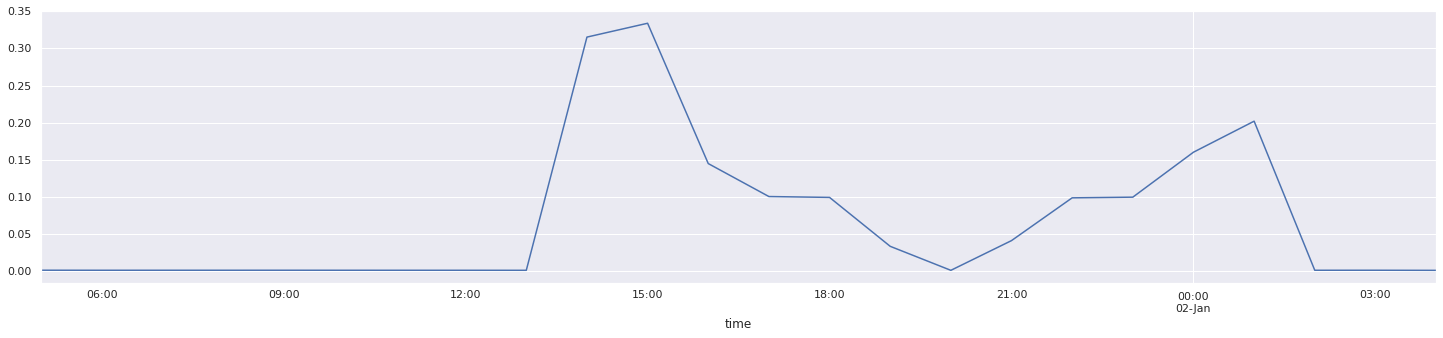

In [137]:
energy_df['Living room'].resample(rule='H').mean().iloc[0:24].plot(figsize=(25,5)) #Living room power usage for  24 hours ( 1 Day )

# Distribution Living Room power Usage from the observations

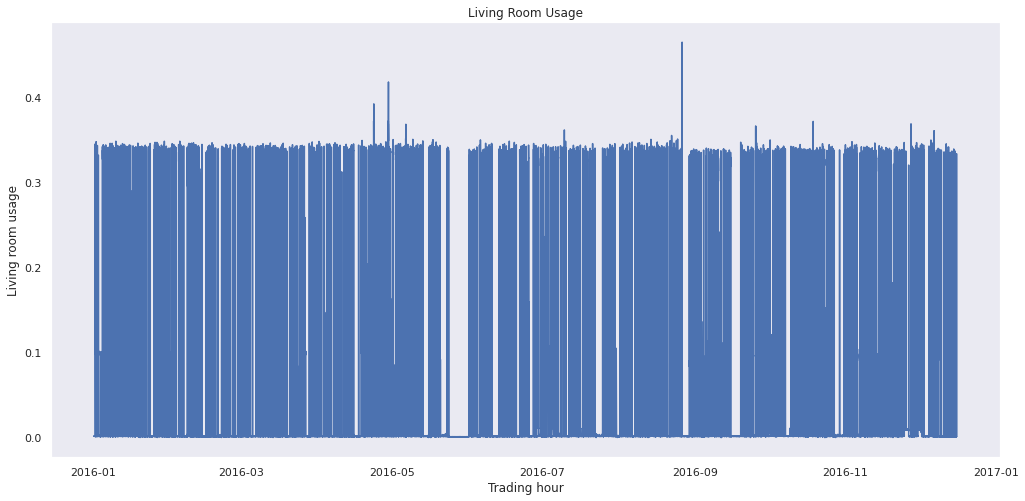

In [138]:


plt.figure(figsize=(17, 8))
plt.plot(energy_df['Living room'])
plt.title('Living Room Usage')
plt.ylabel('Living room usage')
plt.xlabel('Trading hour')
plt.grid(False)
plt.show()

# Hourly Trend in Living Room 


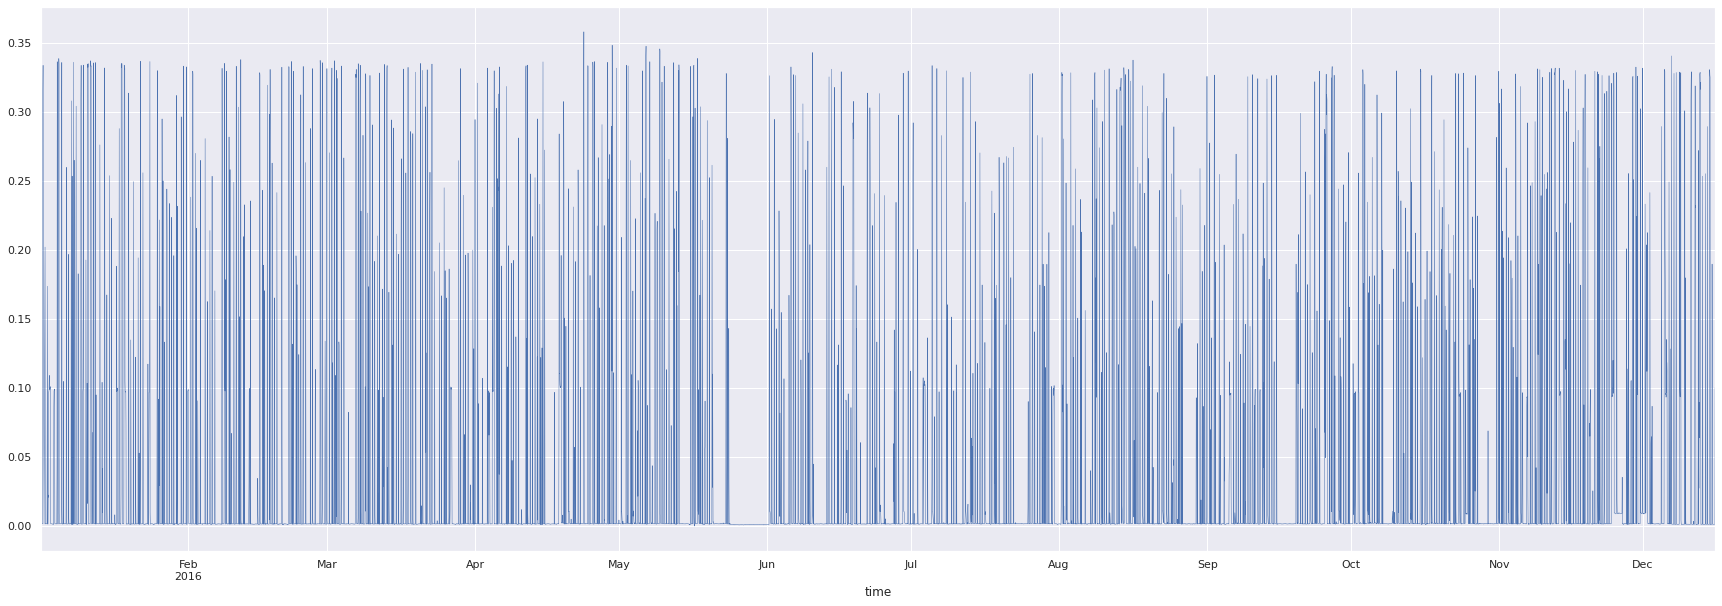

In [139]:
energy_df['Living room'].resample(rule='H').mean().plot(figsize=(30,10),linewidth=0.5)

###Hourly Trend in Living Room with Simple Moving Average of window 60 ( 60 minutes = 1 hour )

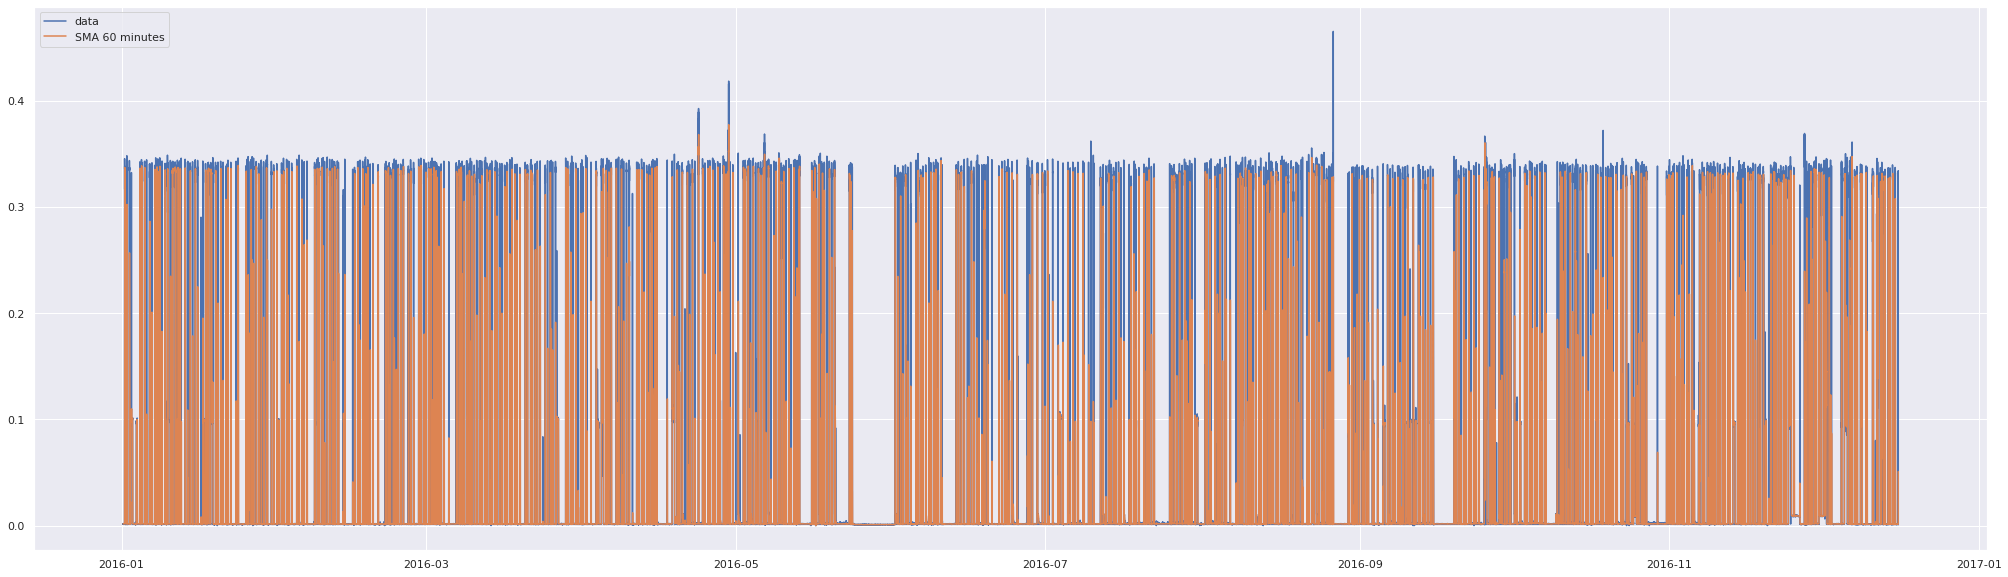

In [140]:
energy_df['Living_moving_SMA_3'] = energy_df["Living room"].rolling(window=60,min_periods=60).mean()
plt.figure(figsize=[35,10])
plt.grid(True)
plt.plot(energy_df['Living room'],label='data')
plt.plot(energy_df['Living_moving_SMA_3'],label='SMA 60 minutes')
plt.legend(loc=2)

###Hourly Trend in Living Room with Expanding window 60 ( 60 minutes = 1 hour )

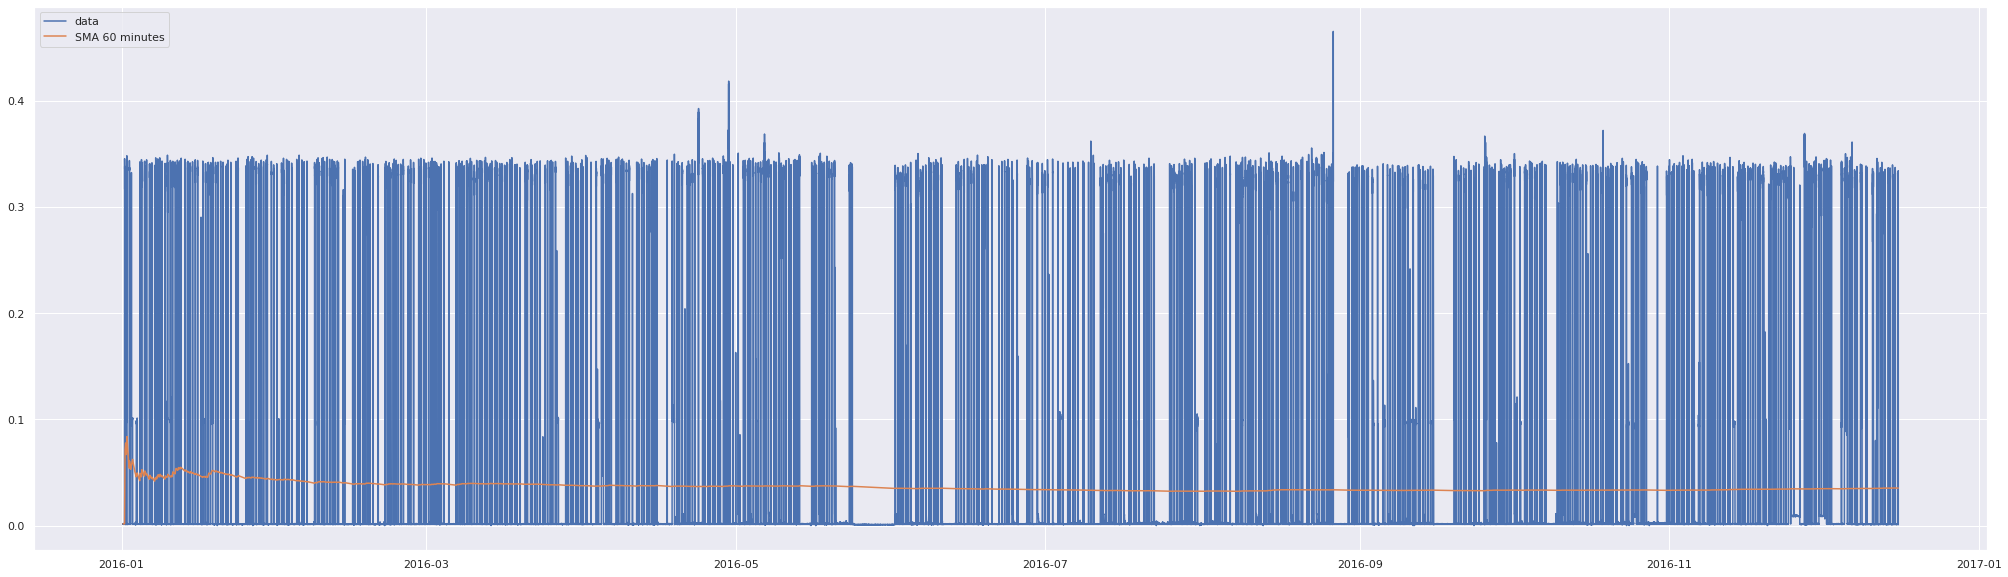

In [141]:
energy_df['Living_moving_SMA_3'] = energy_df["Living room"].expanding(min_periods=60).mean()
plt.figure(figsize=[35,10])
plt.grid(True)
plt.plot(energy_df['Living room'],label='data')
plt.plot(energy_df['Living_moving_SMA_3'],label='SMA 60 minutes')
plt.legend(loc=2)

## Peak working hours in Home office

[Text(0, 0.5, 'Home Office  Usage (kW) '), Text(0.5, 0, 'Daily Hours')]

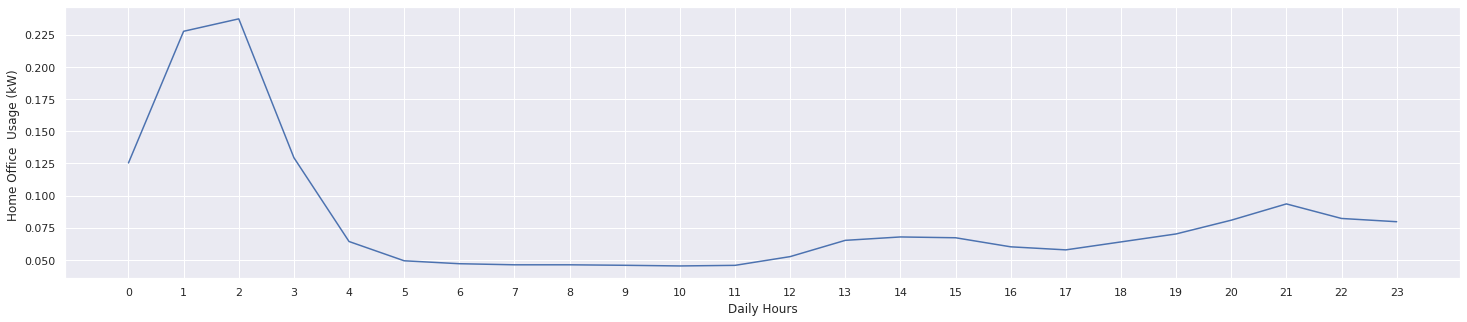

In [142]:
energy_df.groupby(energy_df.index.hour).mean()['Home office'].plot(figsize=(25,5),xticks=np.arange(24)).set(xlabel='Daily Hours', ylabel='Home Office  Usage (kW) ')

From the above graph ,The most peak working hours are the initial 4 hours in Home office .At 11th hour there is slight peak and fall at 16 . After 16th hour there is monotonic rise in the working hours

Averge hour peaks observed from the overall observations

In [143]:
indices = find_peaks(energy_df.groupby(energy_df.index.hour).mean()['Home office'])[0]

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=energy_df.groupby(energy_df.index.hour).mean()['Home office'],
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=indices,
    y=[energy_df.groupby(energy_df.index.hour).mean()['Home office'][j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
))

fig.show()

In [144]:
#Distribution of peaks on the overall Home office 
indices = find_peaks(house_data['Home office'].resample(rule='H').mean())[0]

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=house_data['Home office'].resample(rule='H').mean(),
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=indices,
    y=[house_data['Home office'].resample(rule='H').mean()[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
))

fig.show()

In [169]:
devices_energy_df = energy_df.filter(items=[ 'Dishwasher',
                                     'Furnace 1', 'Furnace 2',  'Fridge',
                                     'Garage door', 
                                     'Well',
                                     'Microwave','summary'])
devices_energy_df.head()

,Dishwasher,Furnace 1,Furnace 2,Fridge,Garage door,Well,Microwave,summary
time,,,,,,,,
2016-01-01 05:58:00,0.000033,0.021083,0.309983,0.005167,0.013183,0.001000,0.004233,Mostly Cloudy
2016-01-01 05:59:00,0.000017,0.096983,0.062867,0.005000,0.012883,0.001017,0.004233,Mostly Cloudy
2016-01-01 06:00:00,0.000017,0.064500,0.062633,0.005017,0.012950,0.001000,0.004233,Mostly Cloudy
2016-01-01 06:01:00,0.000017,0.111333,0.063883,0.004967,0.012883,0.001017,0.004233,Mostly Cloudy
2016-01-01 06:02:00,0.000017,0.114583,0.063200,0.114167,0.012917,0.001000,0.004233,Mostly Cloudy


In [170]:
energy_df["summary"].unique()

array(['Mostly Cloudy', 'Clear', 'Overcast', 'Partly Cloudy', 'Drizzle',
       'Light Rain', 'Rain', 'Light Snow', 'Flurries', 'Breezy', 'Snow',
       'Rain and Breezy', 'Foggy', 'Breezy and Mostly Cloudy',
       'Breezy and Partly Cloudy', 'Flurries and Breezy', 'Dry',
       'Heavy Snow'], dtype=object)

In [171]:
house_data["icon"].unique()

array(['partly-cloudy-night', 'clear-night', 'clear-day', 'cloudy',
       'partly-cloudy-day', 'rain', 'snow', 'wind', 'fog'], dtype=object)

In [172]:
devices_energy_df["summary"].loc[energy_df["summary"].isin(["Clear","Partly Cloudy","Breezy","Breezy and Partly Cloudy"])]="summer"
devices_energy_df["summary"].loc[energy_df["summary"].isin(["Mostly Cloudy","Overcast","Flurries and Breezy","Breezy and Mostly Cloudy","Light Snow","Flurries","Snow","Foggy"])]="winter"


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Power Consumption of Devices in Winter

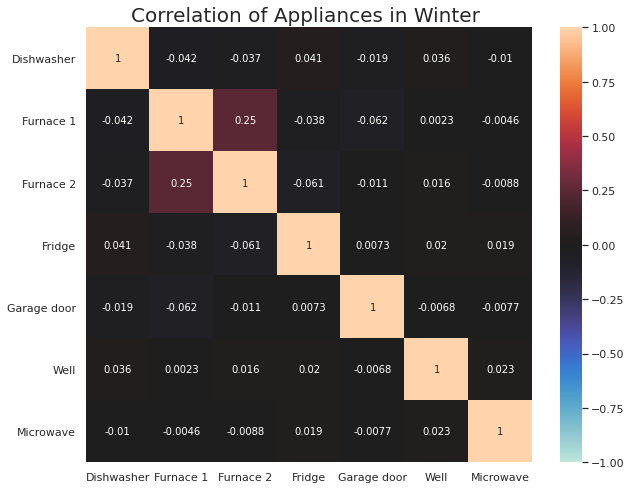

In [173]:

devices_energy_df_winter=devices_energy_df[devices_energy_df['summary']=='winter']
fig,ax = plt.subplots(figsize=(10, 8)) 
corr = devices_energy_df_winter.corr()
sns.heatmap(corr, annot=True, vmin=-1.0, vmax=1.0, center=0)
ax.set_title('Correlation of Appliances in Winter ',size=20)
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Consumption for devices in Winter')

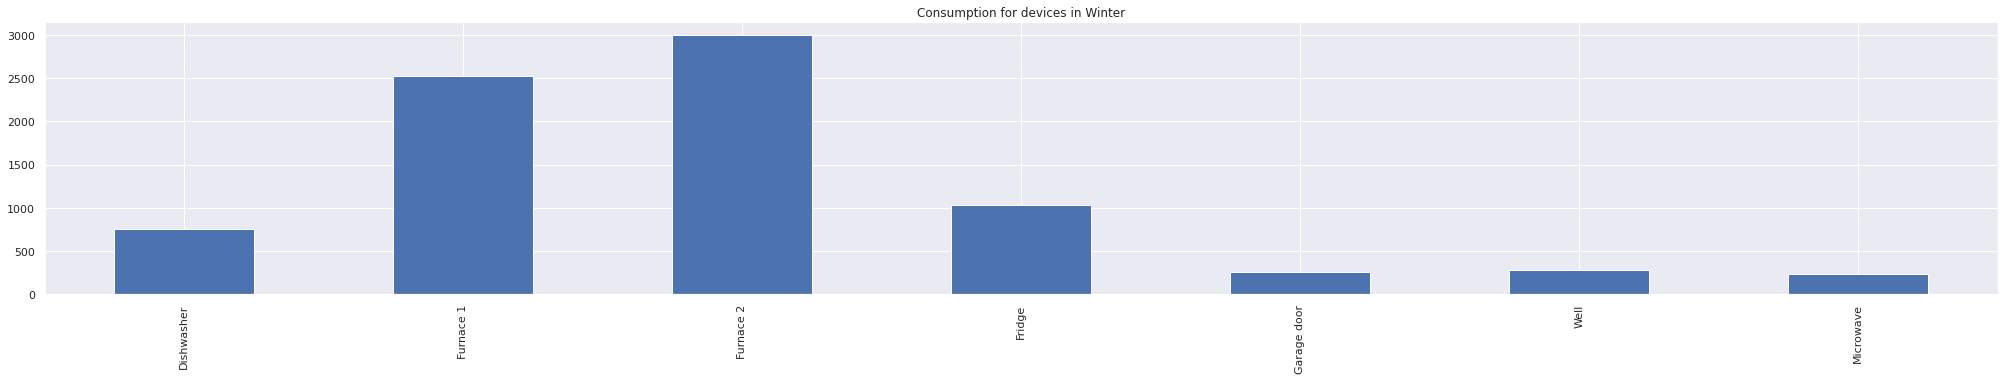

In [174]:
devices_energy_df_winter.drop(['summary'], axis=1, inplace=True)
devices_energy_df_winter.head()
all_devices_energy_consumption_winter=devices_energy_df_winter.sum()
plot = all_devices_energy_consumption_winter.plot(kind = "bar", figsize = (35,5))
plot.set_title("Consumption for devices in Winter")

Power Consumption of Devices in Summer

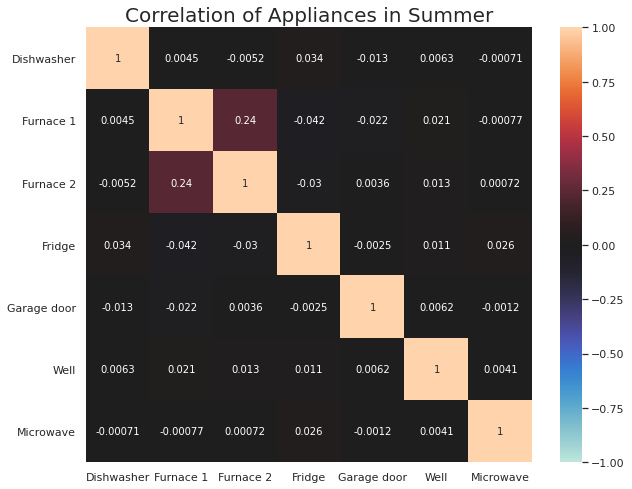

In [175]:
devices_energy_df_summer=devices_energy_df[devices_energy_df['summary']=='summer']
fig,ax = plt.subplots(figsize=(10, 8)) 
corr = devices_energy_df_summer.corr()
sns.heatmap(corr, annot=True, vmin=-1.0, vmax=1.0, center=0)
ax.set_title('Correlation of Appliances in Summer',size=20)
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Consumption for devices in Summer')

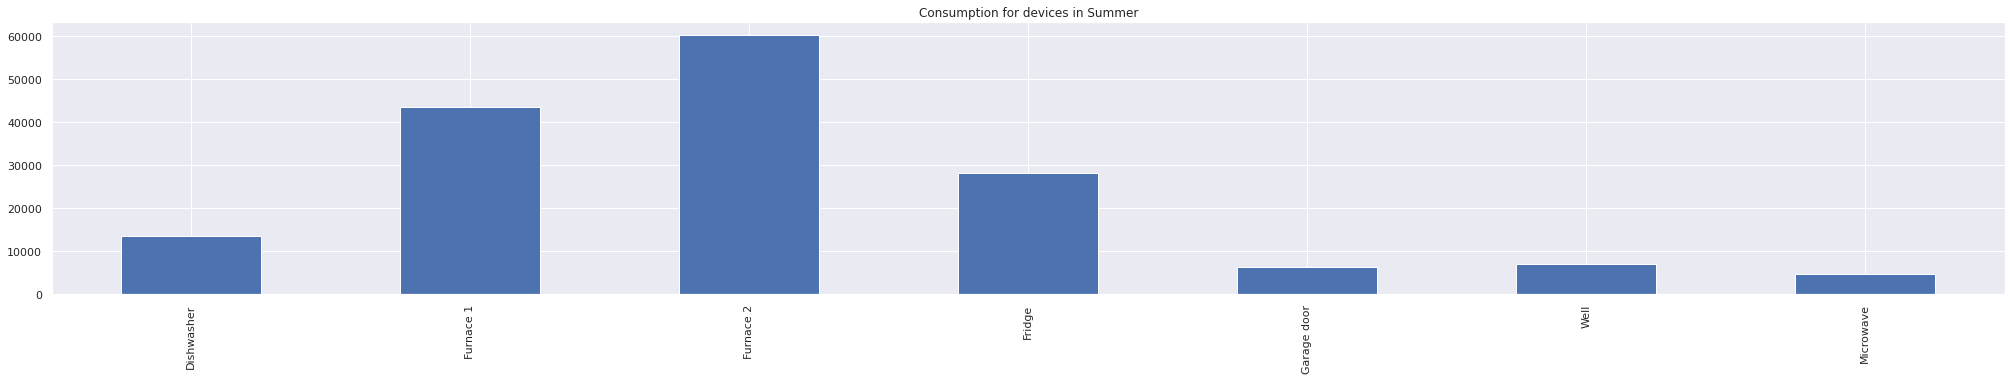

In [176]:
devices_energy_df_summer=devices_energy_df[devices_energy_df['summary']=='summer']
devices_energy_df_summer.drop('summary', axis=1, inplace=True)
all_devices_energy_consumption_summer=devices_energy_df_summer.sum()

plot = all_devices_energy_consumption_summer.plot(kind = "bar", figsize = (35,5))
plot.set_title("Consumption for devices in Summer")

Overall Consumption of devices in Summer and Winter

In [177]:
devices_energy_df.drop('summary', axis=1, inplace=True)
all_devices_energy_consumption=devices_energy_df.sum()
all_devices_energy_consumption

Dishwasher     15806.405743
Furnace 1      49985.102550
Furnace 2      68909.255037
Fridge         32024.449100
Garage door     7124.090616
Well            7882.103335
Microwave       5533.149585
dtype: float64

Text(0.5, 1.0, 'Consumption for devices in both summer and winter')

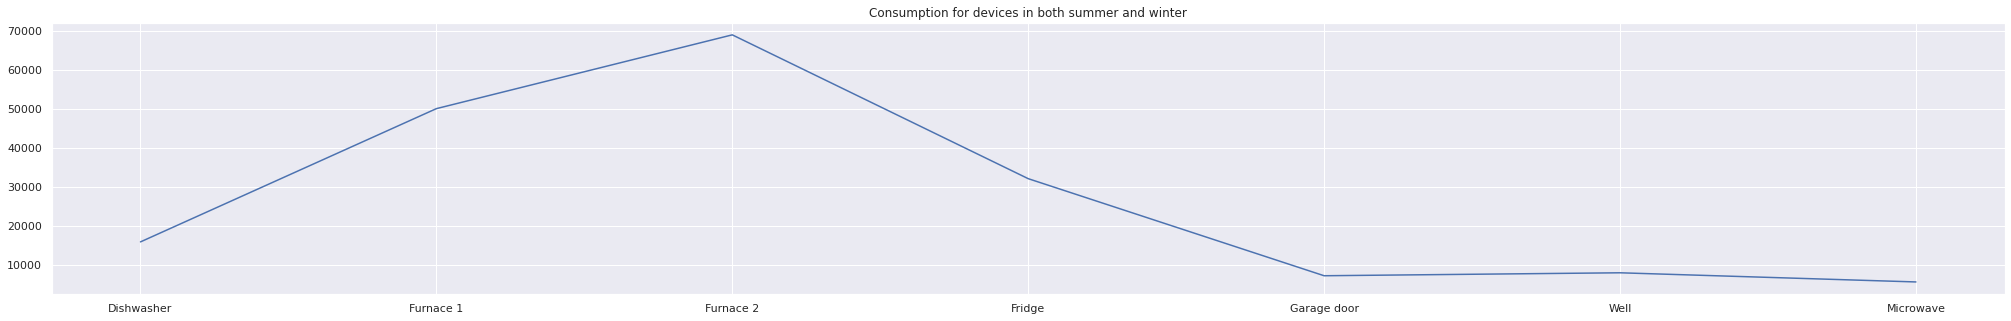

In [178]:
plot = all_devices_energy_consumption.plot(kind = "line", figsize = (35,5))
plot.set_title("Consumption for devices in both summer and winter")


In Summary **Furnace,Fridge,Dishwasher** highest power consumption in both summer and winter